In [1]:
#%%
from distutils.file_util import write_file
import pandas as pd
from pathlib import Path
import yaml
import os
import re
from functools import reduce

with open('config.yaml') as f:
    config = yaml.load(f, yaml.SafeLoader)
os.sys.path.append(config['path_config']['project_path'])

from src.MyModule.utils import *

project_path = Path(config['path_config']['project_path'])
input_path = Path(config['path_config']['input_path'])
output_path = Path(config['path_config']['output_path'])
file_names = list(config['file_name'].keys())

preprocess_output = output_path.joinpath('0_preprocess')

In [2]:
#%%
def read_pkl(path):
    return pd.read_pickle(path)

#%%
def check_duplicates(df):
    counts = df[['PT_SBST_NO','TIME']].duplicated().sum()
    return counts

In [3]:
# %%
all_datas = [read_pkl(preprocess_output.joinpath(file +'.pkl')) for file in file_names]
all_datas = list(map(lambda data : data.reset_index(), all_datas))


print("Check Duplicates Once Again")
print(list(map(check_duplicates, all_datas)))

all_concated = reduce(lambda df1, df2 : pd.merge(df1, df2, how='outer', on=['PT_SBST_NO','TIME']), all_datas)

Check Duplicates Once Again
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


the maximum record is 2137
the minimum record is 1
the median record is 18.0


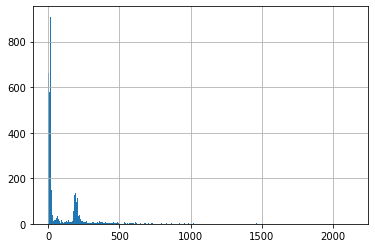

In [5]:
#%%
all_concated.reset_index().groupby(['PT_SBST_NO']).size().hist(bins=1000)
max_record = all_concated.reset_index().groupby(['PT_SBST_NO']).size().max()
min_record = all_concated.reset_index().groupby(['PT_SBST_NO']).size().min()
median = all_concated.reset_index().groupby(['PT_SBST_NO']).size().median()
print(f'the maximum record is {max_record}')
print(f'the minimum record is {min_record}')
print(f'the median record is {median}')


all_concated = all_concated[all_concated['PT_BSNF_BSPT_IDGN_AGE']<50]

all_concated = all_concated.sort_values(by=['PT_SBST_NO','TIME'])

#%%
first_diagnosis = all_concated[all_concated.PT_BSNF_BSPT_FRST_DIAG_YMD == 1][['PT_SBST_NO','TIME']].copy()

#%% filter records before first diagnosis

merged = pd.merge(all_concated,first_diagnosis.rename(columns={'TIME':'first_diagnosis'}))
all_concated = merged.query("TIME >= first_diagnosis").reset_index(drop=True).drop(columns = "first_diagnosis")

In [6]:
#%%
# set valid dtypes

def return_dtype(table_name, col_name):
    dtype_book = config['data_config']['required'][table_name]
    return dtype_book[col_name]

def set_dtypes(col:pd.Series=None, col_name=None):
    '''
    sets the appropriate data type for the column
    '''
    prefix = re.findall('(^\w{2,4}_\w{2,4}_)', col_name)[0]
    if prefix == 'EX_DIAG' :
        real_col_name = col_name.replace(prefix, '')
        col = col.astype('float32')
        return col
    
    index = list(config['data_config']['prefix'].values()).index(prefix)
    table_name = list(config['data_config']['prefix'].keys())[index]
    real_col_name = col_name.replace(prefix, '')
    
    try :
        data_type = return_dtype(table_name, real_col_name)
        if data_type == 'datetime64[ns]':
            data_type = 'float32'
    except :
        data_type = 'float32'
    col = col.astype(data_type)
    
    return col

In [8]:
#%%

all_concated['DG_RCNF_RLPS'] = all_concated['DG_RCNF_RLPS'].astype('float32')
all_concated['DEAD_NFRM_DEAD'] = all_concated['DEAD_NFRM_DEAD'].astype('float32')


#%%
object_columns = all_concated.select_dtypes('object')

def make_encoding(name, col):
    
    vals = col.value_counts().keys()
    unique_vals = list(col.unique())
    return {name : {val : idx for idx, val in enumerate(vals)}}

encoding = {}
for name, col in object_columns.iteritems():
    encoding.update(make_encoding(name, col))

with open(preprocess_output.joinpath('encoding.pkl'), 'wb') as f:
    pickle.dump(encoding, f)

#%%
all_concated = all_concated.replace(encoding)

#%%
for name, col in all_concated.iteritems():
    if (name == 'PT_SBST_NO') | (name == 'TIME'):
        continue 
    all_concated[name] = set_dtypes(col, name)

#%% 
# Forward Bacward fill ExDiag table

fill = all_concated.filter(regex="EX_DIAG|PT_SBST_NO").groupby(['PT_SBST_NO'],as_index=False).transform(lambda v : v.ffill())
msk = all_concated.columns.str.contains('EX_DIAG_')
all_concated[all_concated.columns[msk]]=fill


#%%
frst_ymd = all_concated['PT_BSNF_BSPT_FRST_DIAG_YMD']

fill = all_concated.filter(regex="PT_BSNF|PT_SBST_NO").groupby(['PT_SBST_NO'], as_index=False).transform(lambda v : v.ffill().bfill())
msk = all_concated.columns.str.contains('PT_BSNF_')
all_concated[all_concated.columns[msk]] = fill


#%%
all_concated['PT_BSNF_BSPT_FRST_DIAG_YMD'] = frst_ymd

#%%
all_concated = all_concated.fillna({'DG_RCNF_RLPS':0, 'DEAD_NFRM_DEAD':0})

#%%
change2objectdtype = all_concated.filter(regex='RLPS|DEAD').columns.tolist()
book = {k:"object" for k in change2objectdtype}


#%%
all_concated = all_concated.astype(book)

#%% change to time steps

def test_no_same_row(data):
    if data[['PT_SBST_NO','TIME']].duplicated().sum() == 0 :
        return True
    else :
        return False

assert test_no_same_row(all_concated), "There is a duplicated row"

#%%
all_concated = all_concated.sort_values(by=['PT_SBST_NO','TIME'])

#%%
g = all_concated.groupby(['PT_SBST_NO'], as_index=False).TIME.min()


#%%
days = all_concated.apply(lambda x : (x['TIME'] - g.iloc[x['PT_SBST_NO']]['TIME']).days, axis=1)

all_concated['TIME'] = days

In [10]:
#%%
less_than_30_days_obs = all_concated.groupby('PT_SBST_NO', as_index=False)['TIME'].max().query('TIME < 30')['PT_SBST_NO']
print(f'less than 30 days of observation is {len(less_than_30_days_obs)}')

over_10_years_obs = all_concated.groupby('PT_SBST_NO', as_index=False)['TIME'].max().query('TIME >= 3650')['PT_SBST_NO']
print(f'over 10 years of observation is {len(over_10_years_obs)}')

print(len(all_concated))

less than 30 days of observation is 1501
over 10 years of observation is 0
1501


In [12]:
#print(all_concated)
#%%
exclude_patients = set(less_than_30_days_obs) | set(over_10_years_obs)

#all_concated = all_concated.query('PT_SBST_NO not in @exclude_patients')


#print(len(all_concated))

#print(all_concated)

#%%
if output_path.joinpath('0_preprocess').exists() :
    all_concated.to_pickle(output_path.joinpath('0_preprocess').joinpath('D1.pkl'))
    
else :
    output_path.joinpath('0_preprocess').mkdir(parents=True)
    all_concated.to_pickle(output_path.joinpath('0_preprocess').joinpath('D1.pkl'))

In [13]:
all_concated

,PT_SBST_NO,TIME,DG_RCNF_RLPS,EX_DIAG_CEA,OPRT_NFRM_OPRT_CLCN_OPRT_KIND_CD,OPRT_NFRM_OPRT_CURA_RSCT_CD,PTH_BPSY_BPTH_BPSY_RSLT_CONT,PTH_BPSY_BPTH_CELL_DIFF_CD,PTH_MLCR_MLPT_BRME_RSLT_CD,PTH_MLCR_MLPT_KE2E_RSLT_CD,...,PT_BSNF_BSPT_N_STAG_VL,PT_BSNF_BSPT_SEX_CD,PT_BSNF_BSPT_STAG_VL,PT_BSNF_BSPT_T_STAG_VL,PT_BSNF_BSPT_FRST_DIAG_YMD,TRTM_CASB_CSTR_NT,TRTM_CASB_CSTR_PRPS_CD,TRTM_CASB_CSTR_REGN_CD,TRTM_RD_RDT,DEAD_NFRM_DEAD
0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0
998,1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0
1007,2,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0
1006,3,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0
1005,4,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1,2.0,3.0,1.0,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,1496,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1,2.0,3.0,1.0,NaN,NaN,NaN,NaN,0.0
497,1497,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0
496,1498,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1,1.0,2.0,1.0,NaN,NaN,NaN,NaN,0.0
495,1499,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1,1.0,2.0,1.0,NaN,NaN,NaN,NaN,0.0


In [16]:
D1 = pd.read_pickle('/mnt/synthetic_data/data/processed/0_preprocess/D1.pkl')

In [21]:
D1

,PT_SBST_NO,TIME,DG_RCNF_RLPS,EX_DIAG_CEA,OPRT_NFRM_OPRT_CLCN_OPRT_KIND_CD,OPRT_NFRM_OPRT_CURA_RSCT_CD,PTH_BPSY_BPTH_BPSY_RSLT_CONT,PTH_BPSY_BPTH_CELL_DIFF_CD,PTH_MLCR_MLPT_BRME_RSLT_CD,PTH_MLCR_MLPT_KE2E_RSLT_CD,...,PT_BSNF_BSPT_N_STAG_VL,PT_BSNF_BSPT_SEX_CD,PT_BSNF_BSPT_STAG_VL,PT_BSNF_BSPT_T_STAG_VL,PT_BSNF_BSPT_FRST_DIAG_YMD,TRTM_CASB_CSTR_NT,TRTM_CASB_CSTR_PRPS_CD,TRTM_CASB_CSTR_REGN_CD,TRTM_RD_RDT,DEAD_NFRM_DEAD
0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0
998,1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0
1007,2,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0
1006,3,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0
1005,4,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1,2.0,3.0,1.0,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,1496,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1,2.0,3.0,1.0,NaN,NaN,NaN,NaN,0.0
497,1497,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0
496,1498,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1,1.0,2.0,1.0,NaN,NaN,NaN,NaN,0.0
495,1499,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1,1.0,2.0,1.0,NaN,NaN,NaN,NaN,0.0
